In [167]:
import os, sys, time, re, json, pickle
import numpy as np
import pandas as pd

from tqdm import tqdm
import scipy.stats as ss

import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import style
style.use('ggplot')
style.use('seaborn-white')

In [2]:
celltype_map_1k = {'CD4T': ['cd4et', 'cd4nc', 'cd4sox4'],
                   'CD8T': ['cd8et', 'cd8nc', 'cd8s100b'],
                   'monocyte': ['monoc', 'mononc'],
                   'B': ['bin', 'bmem', 'plasma'],
                   'NK': ['nk', 'nkr'],
                   'DC': ['dc']}
celltype_map_1k_inv = {}
for k, v in celltype_map_1k.items():
    for x in v:
        celltype_map_1k_inv[x] = k
celltype_map_1k_inv

{'cd4et': 'CD4T',
 'cd4nc': 'CD4T',
 'cd4sox4': 'CD4T',
 'cd8et': 'CD8T',
 'cd8nc': 'CD8T',
 'cd8s100b': 'CD8T',
 'monoc': 'monocyte',
 'mononc': 'monocyte',
 'bin': 'B',
 'bmem': 'B',
 'plasma': 'B',
 'nk': 'NK',
 'nkr': 'NK',
 'dc': 'DC'}

# Data preparation

## Merge 1M with 1000G reference panel

In [ ]:
### 1000G genotype quality control: keep snps with maf > 0.01
for chrom in range(1, 23):
    command = f'plink \
                --bfile ../data/S-LDXR/1000G_EAS_EUR/EUR/1000G.EUR.QC.{chrom} \
                --maf 0.01 \
                --make-bed \
                --out ../data/S-LDXR/1000G_EAS_EUR_maf0.01/EUR/1000G.EUR.QC.{chrom}'
    print(command, '\n')

In [34]:
### concat all bims
bims = []
for chrom in range(1, 23):
    bim = pd.read_csv(f'../data/S-LDXR/1000G_EAS_EUR_maf0.01/EUR/1000G.EUR.QC.{chrom}.bim', sep='\t', header=None)
    bims.append(bim)
bims_df = pd.concat(bims)
bims_df.columns = ['CHR', 'SNP', 'CM', 'BP', 'A1', 'A2']
bims_df.to_csv('../data/S-LDXR/1000G_EAS_EUR_maf0.01/all_chroms.bim', sep='\t', index=False)

In [187]:
### merge maf001 with 1m by cell type
## 1000G maf001 snps
bims_df = pd.read_csv('../data/S-LDXR/1000G_EAS_EUR_maf0.01/all_chroms.bim', sep='\t')
maf001_allsnps = pd.read_csv('../data/S-LDXR/1000G_EAS_EUR_maf0.01/print_snps.txt', sep='\t', header=None)[0].values.tolist()
print(f'{len(maf001_allsnps)} SNPs in 1000G maf001')
for celltype in ['CD4T', 'CD8T', 'monocyte', 'B', 'NK', 'DC']:
    savefile = f'../data/blood_data/1M/gene_snp_pairs_1M/{celltype}_pairs.csv'
    ## 1m
    t0 = time.time()
    df_1m = pd.read_csv(f'../data/1M-scBloodNL/eqtls_genome/UT/{celltype}_expression_eQTLsFDR-ProbeLevel.txt.gz', sep='\t', compression='gzip')
    print(f'Loaded 1M {celltype} {df_1m.shape}')
    ## merge 1m with 1000G maf001
    df_1m_in_maf001_snps = pd.merge(bims_df, df_1m, left_on='SNP', right_on='SNPName') # based on 1kg
    print(f'{len(np.unique(df_1m.SNPName.values))} SNPs in original df_1m, left {len(np.unique(df_1m_in_maf001_snps.SNPName.values))} SNPs after merging with 1000G maf001')
    ## save basic info columns
    df_1m_in_maf001_snps[['SNP', 'CHR', 'BP', 'CM', 'A1', 'A2', 'ProbeName', 'HGNCName', 'ProbeCenterChrPos']].to_csv(savefile, sep='\t', index=None)
    t1 = time.time()
    print(f'Saved df_1m_in_maf001_snps {df_1m_in_maf001_snps.shape}')
    print(f'{celltype} | Time: {t1 - t0:.1f}s\n')

8534993 SNPs in 1000G maf001
Loaded 1M CD4T (4366038, 22)
1788613 SNPs in original df_1m, left 1734235 SNPs after merging with 1000G maf001
Saved df_1m_in_maf001_snps (4200917, 28)
CD4T | Time: 64.3s

Loaded 1M CD8T (4235175, 22)
1754596 SNPs in original df_1m, left 1701165 SNPs after merging with 1000G maf001
Saved df_1m_in_maf001_snps (4072540, 28)
CD8T | Time: 63.7s

Loaded 1M monocyte (4230226, 22)
1763642 SNPs in original df_1m, left 1709995 SNPs after merging with 1000G maf001
Saved df_1m_in_maf001_snps (4072321, 28)
monocyte | Time: 64.3s

Loaded 1M B (3440037, 22)
1565725 SNPs in original df_1m, left 1516648 SNPs after merging with 1000G maf001
Saved df_1m_in_maf001_snps (3302671, 28)
B | Time: 52.8s

Loaded 1M NK (4067040, 22)
1718734 SNPs in original df_1m, left 1665957 SNPs after merging with 1000G maf001
Saved df_1m_in_maf001_snps (3909828, 28)
NK | Time: 61.5s

Loaded 1M DC (3779927, 22)
1656306 SNPs in original df_1m, left 1605226 SNPs after merging with 1000G maf001
Save

In [223]:
### merge union of all pairs
t0 = time.time()
df1 = pd.read_csv('../data/blood_data/1M/gene_snp_pairs_1M/CD4T_pairs.csv', sep='\t')
for celltype in ['CD8T', 'monocyte', 'B', 'NK', 'DC']:
    df2 = pd.read_csv(f'../data/blood_data/1M/gene_snp_pairs_1M/{celltype}_pairs.csv', sep='\t')
    print(celltype, df1.shape, df2.shape)
    df1 = pd.merge(df1, df2, how='outer')
print(df1.shape)
df1 = df1.sort_values(by=['CHR', 'BP'])
df1.to_csv('../data/blood_data/1M/gene_snp_pairs_1M/all_celltype_pairs.csv', sep='\t', index=False)
t1 = time.time()
print(f'Time: {t1 - t0:.1f}s')

## Create annotation matrix for calculating LD score

In [225]:
### create annotation matrix from pairs
pairs_1m = pd.read_csv('../data/blood_data/1M/gene_snp_pairs_1M/all_celltype_pairs.csv', sep='\t')
print(pairs_1m.shape)

(4483320, 9)


In [231]:
gene_ids_1m = np.unique(pairs_1m.ProbeName.values)
print(f'{len(gene_ids_1m)} gene_ids in 1M all celltype pairs')
for chrom in range(1, 23):
    savefile = f'../data/blood_data/1M/annotations/{chrom}.annot.gz'
    gene_snp_map_1m = pairs_1m[pairs_1m.CHR==chrom][['SNP', 'ProbeName']].groupby('ProbeName')['SNP'].apply(list).to_dict()
    annot = pairs_1m.loc[pairs_1m.CHR==chrom][['CHR', 'BP', 'SNP', 'CM']]
    annot = annot.drop_duplicates(subset=['SNP'])
    annot['base'] = 1
    for gene, snps in tqdm(gene_snp_map_1m.items()):
        annot[gene] = 0
        annot.loc[annot.SNP.isin(snps), gene] = 1
    genes_per_snp = annot.iloc[:,5:].sum(1)
    snps_per_gene = annot.iloc[:,5:].sum(0)
    print(f'CHR {chrom} | {min(genes_per_snp)}-{max(genes_per_snp)} genes per snp, {min(snps_per_gene)}-{max(snps_per_gene)} snps per gene')
    annot.to_csv(savefile, sep='\t', index=False, compression='gzip')

17825 gene_ids in 1M all celltype pairs


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1902/1902 [00:32<00:00, 58.80it/s]


CHR 1 | 1-20 genes per snp, 1-727 snps per gene


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1244/1244 [00:19<00:00, 64.86it/s]


CHR 2 | 1-18 genes per snp, 1-663 snps per gene


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1062/1062 [00:14<00:00, 70.93it/s]


CHR 3 | 1-15 genes per snp, 8-849 snps per gene


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 661/661 [00:08<00:00, 79.33it/s]


CHR 4 | 1-9 genes per snp, 5-728 snps per gene


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 826/826 [00:10<00:00, 79.41it/s]


CHR 5 | 1-13 genes per snp, 2-592 snps per gene


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 958/958 [00:12<00:00, 76.07it/s]


CHR 6 | 1-22 genes per snp, 2-644 snps per gene


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 849/849 [00:10<00:00, 79.03it/s]


CHR 7 | 1-16 genes per snp, 4-688 snps per gene


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 682/682 [00:08<00:00, 84.43it/s]


CHR 8 | 1-18 genes per snp, 5-1069 snps per gene


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 692/692 [00:07<00:00, 90.62it/s]


CHR 9 | 1-18 genes per snp, 10-737 snps per gene


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 694/694 [00:08<00:00, 83.55it/s]


CHR 10 | 1-12 genes per snp, 1-653 snps per gene


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1016/1016 [00:12<00:00, 81.37it/s]


CHR 11 | 1-22 genes per snp, 2-696 snps per gene


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 941/941 [00:11<00:00, 78.51it/s]


CHR 12 | 1-17 genes per snp, 2-656 snps per gene


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 289/289 [00:02<00:00, 123.41it/s]


CHR 13 | 1-7 genes per snp, 7-610 snps per gene


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 603/603 [00:06<00:00, 98.85it/s]


CHR 14 | 1-24 genes per snp, 3-677 snps per gene


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 584/584 [00:05<00:00, 100.53it/s]


CHR 15 | 1-11 genes per snp, 1-591 snps per gene


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 892/892 [00:09<00:00, 96.30it/s]


CHR 16 | 1-20 genes per snp, 1-828 snps per gene


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1155/1155 [00:13<00:00, 88.21it/s]


CHR 17 | 1-22 genes per snp, 1-577 snps per gene


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 285/285 [00:02<00:00, 129.00it/s]


CHR 18 | 1-7 genes per snp, 7-554 snps per gene


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1360/1360 [00:15<00:00, 88.52it/s]


CHR 19 | 1-17 genes per snp, 3-833 snps per gene


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 460/460 [00:04<00:00, 110.95it/s]


CHR 20 | 1-13 genes per snp, 17-593 snps per gene


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 206/206 [00:01<00:00, 166.88it/s]


CHR 21 | 1-10 genes per snp, 64-638 snps per gene


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 464/464 [00:03<00:00, 121.66it/s]


CHR 22 | 1-18 genes per snp, 2-596 snps per gene


In [232]:
## save print snps
print_snps = pd.unique(pairs_1m.SNP.values)
print(f'{len(print_snps)} snps in pairs_1m')
with open('../data/blood_data/1M/annotations/all_chroms.print_snps.txt', 'w') as f:
    for x in print_snps:
        f.write(x + '\n')

1814864 snps in pairs_1m


In [233]:
## print snps by chrom for subsetting genotype
n = 0
for chrom in range(1, 23):
    print_snps_chr = pd.unique(pairs_1m.loc[pairs_1m.CHR==chrom].SNP.values)
    print(chrom, len(print_snps_chr))
    n += len(print_snps_chr)
    with open(f'../data/blood_data/1M/annotations/{chrom}.print_snps.txt', 'w') as f:
        for x in print_snps_chr:
            f.write(x + '\n')
print('Total', n)

1 170072
2 144566
3 121229
4 101805
5 100711
6 108486
7 100871
8 89652
9 73804
10 92081
11 92782
12 91237
13 46450
14 60445
15 59867
16 58695
17 72803
18 44364
19 73395
20 48962
21 27179
22 35408
Total 1814864


## Merge 1M, OneK1K and GTEx data by sub cell types

In [236]:
### process gtex
df_gtex_with_rsid = pd.read_csv('../data/GTEx/whole_blood/all_associations.txt.gz', sep='\t')
df_gtex_with_rsid['ensemble_id'] = df_gtex_with_rsid['gene_id'].map(lambda x: x.split('.')[0])
df_gtex_with_rsid['A2'] = df_gtex_with_rsid.variant_id.map(lambda x: x.split('_')[3])
df_gtex_with_rsid['A1'] = df_gtex_with_rsid.variant_id.map(lambda x: x.split('_')[2])
df_gtex = df_gtex_with_rsid[['rs_id_dbSNP151_GRCh38p7', 'ensemble_id', 'A1', 'A2', 'slope', 'slope_se', 'pval_nominal']]
df_gtex.columns = ['SNP_GTEX', 'GENEID_GTEX', 'A1_GTEX', 'A2_GTEX', 'BETA_GTEX', 'SE_GTEX', 'PVAL_GTEX']

In [237]:
stats_highres = {'1M vs OneK1K':
                 {'Shared genes': {}, 'Only 1M genes': {}, 'Only OneK1K genes': {}},
                 '1M vs GTEx':
                 {'Shared genes': {}, 'Only 1M genes': {}, 'Only OneK1K genes': {}},
                 'OneK1K vs GTEx':
                 {'Shared genes': {}, 'Only 1M genes': {}, 'Only OneK1K genes': {}}
                }
for celltype in ['CD4T', 'CD8T', 'monocyte', 'B', 'NK', 'DC']:
    print(f'***** Process {celltype} *****')
    ### process 1m
    t0 = time.time()
    df_1m = pd.read_csv(f'../data/1M-scBloodNL/eqtls_genome/UT/{celltype}_expression_eQTLsFDR-ProbeLevel.txt.gz', sep='\t', compression='gzip')
    print(f'Loaded 1M {celltype} {df_1m.shape}')
    # reverse allele
    df_1m['A1'] = df_1m.SNPType.map(lambda x: x.split('/')[0])
    df_1m['A2'] = df_1m.SNPType.map(lambda x: x.split('/')[1])
    rev_ids = (df_1m.AlleleAssessed != df_1m.A2)
    print(f'1M: {sum(rev_ids)} AssessedAllele != A2, need to reverse')
    df_1m.loc[rev_ids, ['A1', 'A2']] = df_1m.loc[rev_ids, ['A2', 'A1']].values
    # effect size
    df_1m['N'] = df_1m.DatasetsNrSamples.map(lambda x: sum([int(s) for s in x.split(';')]))
    df_1m['SE'] = 1/df_1m['N']**.5
    df_1m['BETA'] = df_1m.OverallZScore * df_1m.SE
    df_1m = df_1m[['SNPChr', 'SNPChrPos', 'SNPName', 'ProbeName', 'HGNCName', 'A1', 'A2', 'BETA', 'SE', 'PValue']]
    df_1m.columns = ['CHR', 'BP', 'SNP_1M', 'GENEID_1M', 'GENENAME_1M', 'A1_1M', 'A2_1M', 'BETA_1M', 'SE_1M', 'PVAL_1M']
    ### load pairs (1M merged with 1000G ref)
    pairs = pd.read_csv(f'../data/blood_data/1M/gene_snp_pairs_1M/{celltype}_pairs.csv', sep='\t')
    pairs.columns = ['SNP_1M', 'CHR_1KG', 'BP_1KG', 'CM_1KG', 'A1_1KG', 'A2_1KG', 'GENEID_1M', 'GENENAME_1M', 'GENECENTER_1M']
    print(f'1M pairs (merged with 1000G maf0.01 ref): {pairs.shape}')
    
    sub_celltypes = celltype_map_1k[celltype]
    for sub_celltype in sub_celltypes:
        t0 = time.time()
        print(f'--- {sub_celltype} ---')
        ### process 1k1k
        df = pd.read_csv(f'../data/OneK1K/eqtl_tables/{sub_celltype}_eqtl_table.tsv.gz', sep='\t', compression='gzip')
        df['SE'] = abs(df.SPEARMANS_RHO/ss.norm.ppf(df.P_VALUE/2))
        df = df[['RSID', 'GENE_ID', 'A1', 'A2', 'SPEARMANS_RHO', 'SE', 'P_VALUE', 'ROUND']]
        df.columns = ['SNP_1K1K', 'GENEID_1K1K', 'A1_1K1K', 'A2_1K1K', 'BETA_1K1K', 'SE_1K1K', 'PVAL_1K1K', 'ROUND_1K1K']
        ## merge 1m and 1k1k
        merged_1m_1k = pd.merge(df_1m, df, left_on=['SNP_1M', 'GENEID_1M'], right_on=['SNP_1K1K', 'GENEID_1K1K'], how='inner')
        print(f'Merged 1M and 1K1K: df_1m {df_1m.shape}, df_1k {df.shape}, merged_1m_1k {merged_1m_1k.shape}')
        ## merge with gtex
        merged_1m_1k_gtex = pd.merge(merged_1m_1k, df_gtex, left_on=['SNP_1M', 'GENEID_1M'], right_on=['SNP_GTEX', 'GENEID_GTEX'], how='inner')
        print(f'Merged 1M, 1K1K and GTEX: merged_1m_1k {merged_1m_1k.shape}, df_gtex_with_rsid {df_gtex.shape}, merged_1m_1k_gtex {merged_1m_1k_gtex.shape}')
        ## merge with all_pairs (1m merged with 1000G maf0.01)
        merged_1m_1k_gtex_maf001 = pd.merge(pairs[['SNP_1M', 'A1_1KG', 'A2_1KG', 'GENEID_1M']], merged_1m_1k_gtex, on=['SNP_1M', 'GENEID_1M'], how='inner')
        print(f'Merged 1M, 1K1K, GTEX and maf001: merged_1m_1k_gtex {merged_1m_1k_gtex.shape}, pairs {pairs.shape}, merged_1m_1k_gtex_maf001 {merged_1m_1k_gtex_maf001.shape}')
        ## remove ambiguous snps (A1A2 != 1000G A1A2)
        tmp = merged_1m_1k_gtex_maf001.reset_index(drop=True)
        l0 = len(tmp)
        snps_rm_ids1 = ~(((tmp.A1_1M==tmp.A1_1KG) & (tmp.A2_1M==tmp.A2_1KG)) | ((tmp.A1_1M==tmp.A2_1KG) & (tmp.A2_1M==tmp.A1_1KG)))
        snps_rm_ids2 = ~(((tmp.A1_1K1K==tmp.A1_1KG) & (tmp.A2_1K1K==tmp.A2_1KG)) | ((tmp.A1_1K1K==tmp.A2_1KG) & (tmp.A2_1K1K==tmp.A1_1KG)))
        snps_rm_ids3 = ~(((tmp.A1_GTEX==tmp.A1_1KG) & (tmp.A2_GTEX==tmp.A2_1KG)) | ((tmp.A1_GTEX==tmp.A2_1KG) & (tmp.A2_GTEX==tmp.A1_1KG)))
        snps_rm_ids = (snps_rm_ids1 | snps_rm_ids2 | snps_rm_ids3)
        tmp = tmp.loc[~snps_rm_ids]
        print(f'Removed {l0 - len(tmp)} ambiguous SNPs.')
        ## reverse A1/A2 based on 1000G A1/A2
        rev_ids1 = (tmp.A2_1M!=tmp.A2_1KG)
        rev_ids2 = (tmp.A2_1K1K!=tmp.A2_1KG)
        rev_ids3 = (tmp.A2_GTEX!=tmp.A2_1KG)
        tmp.loc[rev_ids1, ['A1_1M', 'A2_1M']] = tmp.loc[rev_ids1, ['A2_1M', 'A1_1M']].values
        tmp.loc[rev_ids2, ['A1_1K1K', 'A2_1K1K']] = tmp.loc[rev_ids2, ['A2_1K1K', 'A1_1K1K']].values
        tmp.loc[rev_ids3, ['A1_GTEX', 'A2_GTEX']] = tmp.loc[rev_ids3, ['A2_GTEX', 'A1_GTEX']].values
        tmp.loc[rev_ids1, 'BETA_1M'] = -tmp.loc[rev_ids1, 'BETA_1M'].values
        tmp.loc[rev_ids2, 'BETA_1K1K'] = -tmp.loc[rev_ids2, 'BETA_1K1K'].values
        tmp.loc[rev_ids3, 'BETA_GTEX'] = -tmp.loc[rev_ids3, 'BETA_GTEX'].values
        print(f'Reversed A1/A2: 1M {sum(rev_ids1)}, 1K1K {sum(rev_ids2)}, GTEX {sum(rev_ids3)}')
        tmp = tmp.drop(['A1_1M', 'A2_1M', 'A1_1K1K', 'A2_1K1K', 'A1_GTEX', 'A2_GTEX', 'GENEID_1K1K', 'GENEID_GTEX'], axis=1)
        tmp.to_csv(f'../data/blood_data/1M/merged_sumstats/sub_celltypes/{sub_celltype}.txt.gz', sep='\t', compression='gzip')
        print(f'Saved combined sumstats ({tmp.shape}).')
        
        ## significance overlap
        pval_thres = 1e-5
        sig_1m = tmp.loc[tmp.PVAL_1M < pval_thres]
        sig_1k = tmp.loc[tmp.PVAL_1K1K < pval_thres]
        sig_gtex = tmp.loc[tmp.PVAL_GTEX < pval_thres]
        # sig genes
        sig_1m_genes = np.unique(sig_1m.GENEID_1M.values)
        sig_1k_genes = np.unique(sig_1k.GENEID_1M.values)
        sig_gtex_genes = np.unique(sig_gtex.GENEID_1M.values)
        sig_common_genes = np.intersect1d(sig_1m_genes, sig_1k_genes)
        sig_only_1m_genes = np.setdiff1d(sig_1m_genes, sig_1k_genes)
        sig_only_1k_genes = np.setdiff1d(sig_1k_genes, sig_1m_genes)
        stats_highres['1M vs OneK1K']['Shared genes'][sub_celltype] = len(sig_common_genes)
        stats_highres['1M vs OneK1K']['Only 1M genes'][sub_celltype] = len(sig_only_1m_genes)
        stats_highres['1M vs OneK1K']['Only OneK1K genes'][sub_celltype] = len(sig_only_1k_genes)
        print(f'1M vs OneK1K | Common: {len(sig_common_genes)}, Only 1M: {len(sig_only_1m_genes)}, Only 1K1K: {len(sig_only_1k_genes)}')
        sig_common_genes = np.intersect1d(sig_1m_genes, sig_gtex_genes)
        sig_only_1m_genes = np.setdiff1d(sig_1m_genes, sig_gtex_genes)
        sig_only_gtex_genes = np.setdiff1d(sig_gtex_genes, sig_1m_genes)
        stats_highres['1M vs GTEx']['Shared genes'][sub_celltype] = len(sig_common_genes)
        stats_highres['1M vs GTEx']['Only 1M genes'][sub_celltype] = len(sig_only_1m_genes)
        stats_highres['1M vs GTEx']['Only OneK1K genes'][sub_celltype] = len(sig_only_gtex_genes)
        print(f'1M vs gtex | Common: {len(sig_common_genes)}, Only 1M: {len(sig_only_1m_genes)}, Only gtex: {len(sig_only_gtex_genes)}')
        sig_common_genes = np.intersect1d(sig_1k_genes, sig_gtex_genes)
        sig_only_1k_genes = np.setdiff1d(sig_1k_genes, sig_gtex_genes)
        sig_only_gtex_genes = np.setdiff1d(sig_gtex_genes, sig_1k_genes)
        stats_highres['OneK1K vs GTEx']['Shared genes'][sub_celltype] = len(sig_common_genes)
        stats_highres['OneK1K vs GTEx']['Only 1M genes'][sub_celltype] = len(sig_only_1k_genes)
        stats_highres['OneK1K vs GTEx']['Only OneK1K genes'][sub_celltype] = len(sig_only_gtex_genes)
        print(f'OneK1K vs gtex | Common: {len(sig_common_genes)}, Only 1K1K: {len(sig_only_1k_genes)}, Only gtex: {len(sig_only_gtex_genes)}')

        ## effect size direction concordance
        tmp2 = tmp.loc[(tmp.PVAL_1M < pval_thres) & (tmp.PVAL_1K1K < pval_thres) & (tmp.PVAL_GTEX < pval_thres)]
        same_direction = sum((tmp2.BETA_1M > 0) & (tmp2.BETA_1K1K > 0) & (tmp2.BETA_GTEX > 0)) + sum((tmp2.BETA_1M < 0) & (tmp2.BETA_1K1K < 0) & (tmp2.BETA_GTEX < 0))
        t1 = time.time()
        print(f'Effect size (pval<1e-5): {same_direction}/{len(tmp2)}={same_direction/len(tmp2):.2f} same direction. [{t1 - t0:.1f}s]\n')


***** Process CD4T *****
Loaded 1M CD4T (4366038, 22)
1M: 1003877 AssessedAllele != A2, need to reverse
1M pairs (merged with 1000G maf0.01 ref): (4200917, 9)
--- cd4et ---
Merged 1M and 1K1K: df_1m (4366038, 10), df_1k (46086529, 8), merged_1m_1k (2974608, 18)
Merged 1M, 1K1K and GTEX: merged_1m_1k (2974608, 18), df_gtex_with_rsid (149431316, 7), merged_1m_1k_gtex (2766686, 25)
Merged 1M, 1K1K, GTEX and maf001: merged_1m_1k_gtex (2766686, 25), pairs (4200917, 9), merged_1m_1k_gtex_maf001 (2726316, 27)
Removed 1349 ambiguous SNPs.
Reversed A1/A2: 1M 2591917, 1K1K 1899179, GTEX 1898414
Saved combined sumstats ((2724967, 19)).
1M vs OneK1K | Common: 228, Only 1M: 97, Only 1K1K: 519
1M vs gtex | Common: 277, Only 1M: 48, Only gtex: 4760
OneK1K vs gtex | Common: 588, Only 1K1K: 159, Only gtex: 4449
Effect size (pval<1e-5): 7603/8138=0.93 same direction. [423.7s]

--- cd4nc ---
Merged 1M and 1K1K: df_1m (4366038, 10), df_1k (59755032, 8), merged_1m_1k (3956600, 18)
Merged 1M, 1K1K and GTEX:

In [238]:
with open('../data/blood_data/1M/merged_sumstats/sub_celltypes/num_genes_1e-5.json', 'w') as f:
    json.dump(stats_highres, f)

In [171]:
### merge sub celltypes
numsnps_per_gene_lists = {}
for celltype in ['CD4T', 'CD8T', 'monocyte', 'B', 'NK', 'DC']:
    print(f'***** Process {celltype} *****')
    sub_celltypes = celltype_map_1k[celltype]
    for sub_celltype in sub_celltypes:
        t0 = time.time()
        df = pd.read_csv(f'../data/blood_data/1M/merged_sumstats/sub_celltypes/{sub_celltype}.txt.gz', sep='\t', index_col=0)
        t1 = time.time()
        print(f'Loaded {sub_celltype}: {t1 - t0:.1f}s')
        snps_per_gene = df[['SNP_1M', 'GENEID_1M']].groupby('GENEID_1M')['SNP_1M'].apply(list).to_dict()
        numsnps_per_gene = {k: len(v) for k, v in snps_per_gene.items()}
        numsnps_per_gene_list = list(numsnps_per_gene.values())
        numsnps_per_gene_lists[sub_celltype] = numsnps_per_gene_list
        print(f'{sub_celltype} | 5th-percentail {np.percentile(numsnps_per_gene_list, 5):.1f}, mean {np.mean(numsnps_per_gene_list):.1f}, median {np.median(numsnps_per_gene_list):.1f}\n')

***** Process CD4T *****
Loaded cd4et: 14.4s
cd4et | 5th-percentail 51.8, mean 240.8, median 235.0

Loaded cd4nc: 16.9s
cd4nc | 5th-percentail 54.0, mean 256.0, median 246.0

Loaded cd4sox4: 7.3s
cd4sox4 | 5th-percentail 51.0, mean 232.7, median 227.0

***** Process CD8T *****
Loaded cd8et: 15.0s
cd8et | 5th-percentail 53.0, mean 246.1, median 239.0

Loaded cd8nc: 14.9s
cd8nc | 5th-percentail 52.7, mean 244.8, median 238.0

Loaded cd8s100b: 12.3s
cd8s100b | 5th-percentail 51.0, mean 238.4, median 232.0

***** Process monocyte *****
Loaded monoc: 12.8s
monoc | 5th-percentail 52.0, mean 239.4, median 234.0

Loaded mononc: 11.0s
mononc | 5th-percentail 51.0, mean 237.4, median 232.0

***** Process B *****
Loaded bin: 13.7s
bin | 5th-percentail 52.0, mean 241.5, median 236.0

Loaded bmem: 13.0s
bmem | 5th-percentail 51.0, mean 239.8, median 235.0

Loaded plasma: 7.0s
plasma | 5th-percentail 51.0, mean 233.4, median 228.0

***** Process NK *****
Loaded nk: 14.2s
nk | 5th-percentail 52.0, me

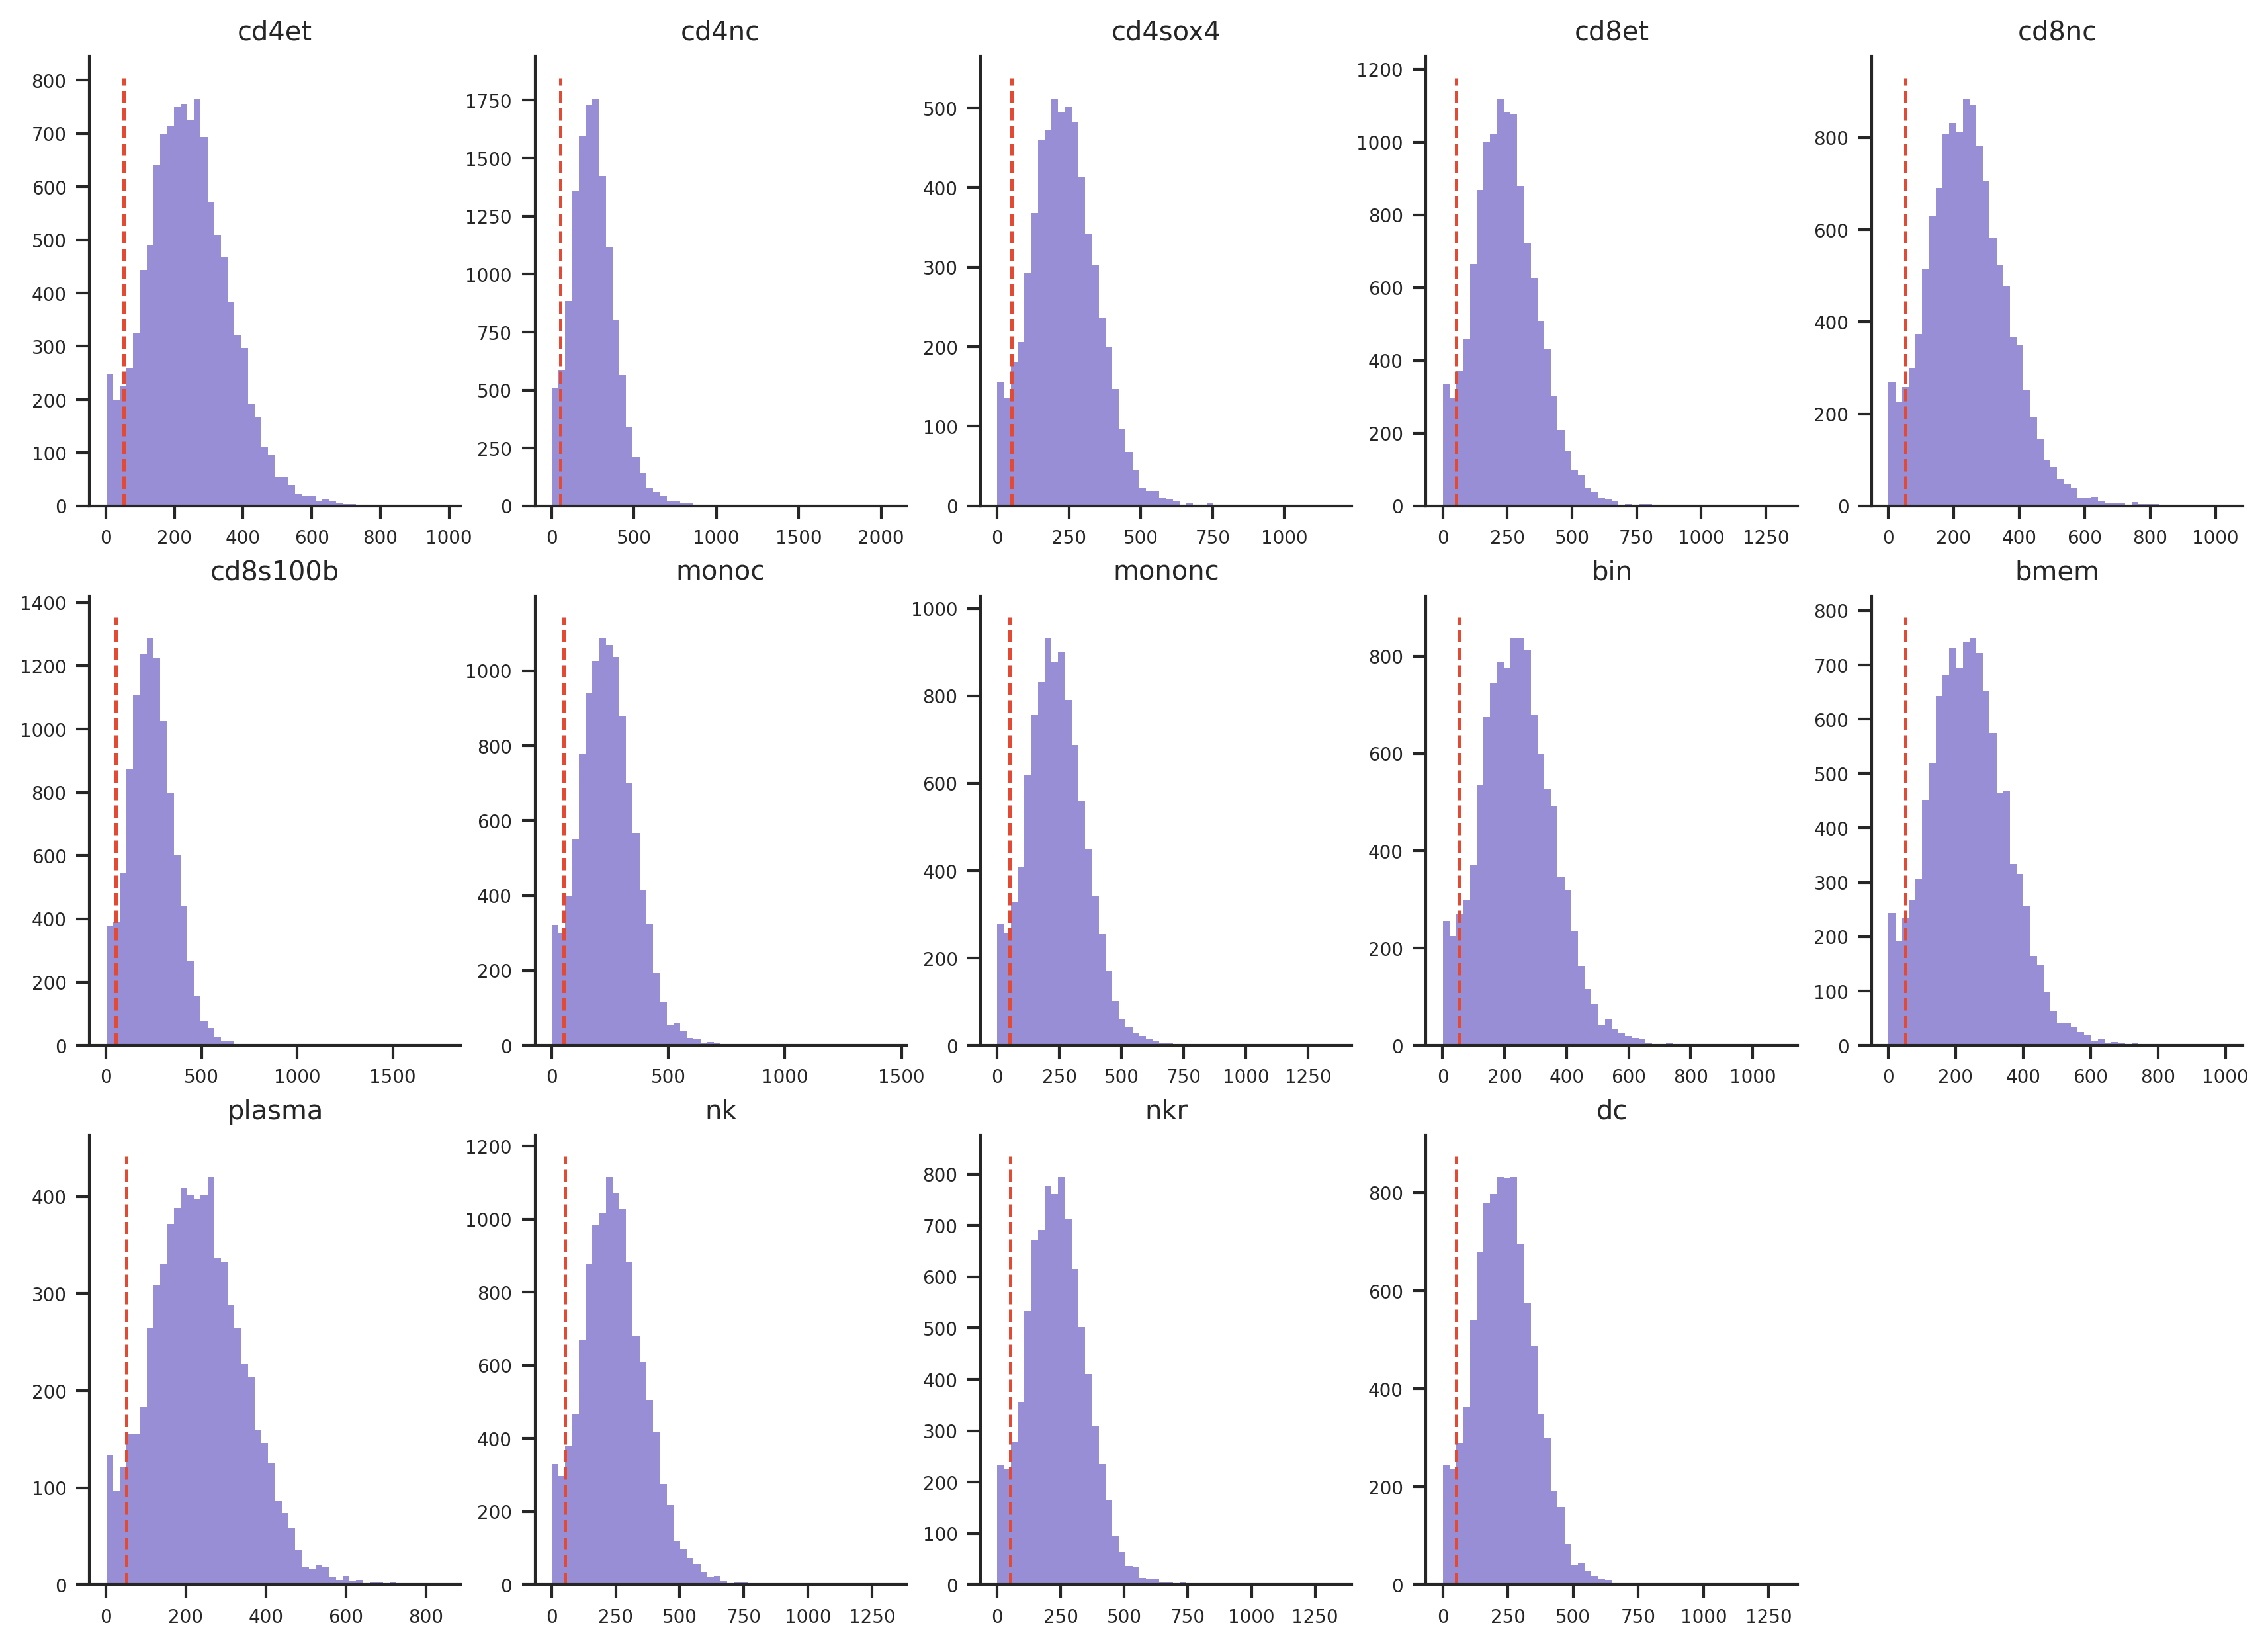

In [185]:
sns.set_context('paper',font_scale=1.)
fig, ax = plt.subplots(3, 5, figsize=(14, 10), dpi=300)
n = 0
keys = list(numsnps_per_gene_lists)
for i in range(3):
    for j in range(5):
        if i==2 and j==4:
            ax[i,j].axis('off')
            break
        k = keys[n]
        v = numsnps_per_gene_lists[k]
        ax[i,j].hist(v, bins=50, color='C2')
        ymin, ymax = ax[i,j].get_ylim()
        p = np.percentile(v, 5)
        ax[i,j].vlines(x=p, ymin=ymin, ymax=ymax, color='C0', linestyle='--')
        ax[i,j].set_title(k, fontsize='medium')
        ax[i,j].spines['top'].set_visible(False)
        ax[i,j].spines['right'].set_visible(False)
        ax[i,j].tick_params(axis='both', which='major', labelsize='x-small')
        ax[i,j].tick_params(axis='both', which='minor', labelsize='x-small')
        n += 1
plt.show()

## Organize data by chrom and gene

In [ ]:
### get snp-gene pair overlap over all sub cell types
pairs_allcelltype = []
t0 = time.time()
for celltype in ['CD4T', 'CD8T', 'monocyte', 'B', 'NK', 'DC']:
    sub_celltypes = celltype_map_1k[celltype]
    pairs = []
    t1 = time.time()
    for sub_celltype in tqdm(sub_celltypes):
        sumstat = pd.read_csv(f'../data/blood_data/1M/merged_sumstats/sub_celltypes/{sub_celltype}.txt.gz', sep='\t', compression='gzip')
        pair = sumstat[['SNP_1M', 'GENEID_1M']].drop_duplicates(keep='first')
        pairs.append(pair)
        print(f'{sub_celltype}: {len(pair)}')
    merged = reduce(lambda  left,right: pd.merge(left,right,on=['SNP_1M', 'GENEID_1M'], how='inner'), pairs)
    t2 = time.time()
    print(f'{celltype} merged: {len(merged)} [{t2 - t1:.1f}s]')
    pairs_allcelltype.append(merged)
merged_allcelltype = reduce(lambda  left,right: pd.merge(left,right,on=['SNP_1M', 'GENEID_1M'], how='inner'), pairs_allcelltype)
t3 = time.time()
print(f'All celltype merged: {len(merged_allcelltype)} [{t3 - t0:.1f}s]')

In [5]:
### keep genes with number of snps among top 95%
snps_per_gene = merged_allcelltype.groupby('GENEID_1M')['SNP_1M'].apply(list).to_dict()
numsnps_per_gene = {k: len(v) for k, v in snps_per_gene.items()}
numsnps_per_gene_df = pd.DataFrame({'GENEID': list(numsnps_per_gene.keys()), 'NUM_SNPS': list(numsnps_per_gene.values())})
numsnp_thres = int(np.percentile(numsnps_per_gene_df.NUM_SNPS.values, 5))
keep_gene_df = numsnps_per_gene_df.loc[numsnps_per_gene_df.NUM_SNPS>numsnp_thres]
print(f'Total {len(snps_per_gene)} genes, keep {len(keep_gene_df)} genes with at least {numsnp_thres+1} SNPs.')

Total 5582 genes, keep 5302 genes with at least 50 SNPs.


In [ ]:
### save sumstats by chrom and gene
for chrom in range(22, 0, -1):
    savedir = f'../data/blood_data/1M/merged_sumstats/by_chrom_gene/chr{chrom}'
    os.makedirs(savedir, exist_ok=True)
    for celltype in ['CD4T', 'CD8T', 'monocyte', 'B', 'NK', 'DC']:
        t0 = time.time()
        print(f'***** Processing CHR {chrom} {celltype} *****')
        sub_celltypes = celltype_map_1k[celltype]
        sub_celltype = sub_celltypes[0]
        sumstat_ = pd.read_csv(f'../data/blood_data/1M/merged_sumstats/sub_celltypes/{sub_celltype}.txt.gz', sep='\t', compression='gzip')
        l0 = len(sumstat_)
        sumstat_ = sumstat_.loc[sumstat_.CHR==chrom].drop_duplicates(subset=['SNP_1M', 'GENEID_1M'])
        l1 = len(sumstat_)
        sumstat = pd.merge(sumstat_, merged_allcelltype, on=['SNP_1M', 'GENEID_1M'], how='inner')
        l2 = len(sumstat)
        keep_sumstat = sumstat.loc[sumstat['GENEID_1M'].isin(keep_gene_df.GENEID)]
        l3 = len(keep_sumstat)
        print(f'original {l0} -> removed duplicates {l1} -> keep pairs in all celltypes {l2} -> keep 95% top genes {l3}')
        g = keep_sumstat.groupby(['GENEID_1M'])
        for i in tqdm(range(len(g.groups))):
            geneid = list(g.groups)[i]
            df = g.get_group(geneid)
            sumstat_1m = df[['CHR', 'BP', 'A1_1KG', 'A2_1KG', 'SNP_1M', 'GENEID_1M', 'GENENAME_1M', 'BETA_1M', 'SE_1M', 'PVAL_1M']]
            sumstat_gtex = df[['CHR', 'BP', 'A1_1KG', 'A2_1KG', 'SNP_1M', 'GENEID_1M', 'GENENAME_1M', 'BETA_GTEX', 'SE_GTEX', 'PVAL_GTEX']]
            sumstat_1m.columns = ['CHR', 'BP', 'A1', 'A2', 'SNP', 'GENEID', 'GENENAME', 'BETA', 'SE', 'PVAL']
            sumstat_gtex.columns = ['CHR', 'BP', 'A1', 'A2', 'SNP', 'GENEID', 'GENENAME', 'BETA', 'SE', 'PVAL']
            sumstat_1m.to_csv(f'{savedir}/{geneid}_{celltype}.csv', sep='\t', index=False)
            sumstat_gtex.to_csv(f'{savedir}/{geneid}_gtex.csv', sep='\t', index=False)
        t1 = time.time()
        print(f'Processed CHR {chrom} {celltype} {t1 - t0:.1f}s.\n')

In [ ]:
## combine all genes
t0 = time.time()
for chrom in range(1, 23):
    for cell_type in celltype_map_1k.keys():
        files = glob.glob(f'../data/blood_data/1M/merged_sumstats/by_chrom_gene/chr{chrom}/*_{cell_type}.csv')
        gene_ids = [x.split('/')[-1].split('_')[0] for x in files if x.split('/')[-1].split('_')[0].startswith('ENSG')]
        dfs = []
        for i, gene_id in tqdm(enumerate(gene_ids)):
            df = pd.read_csv(f'../data/blood_data/1M/merged_sumstats/by_chrom_gene/chr{chrom}/{gene_id}_{cell_type}.csv', sep='\t')
            dfs.append(df)
        dfs = pd.concat(dfs)
        dfs.to_csv(f'../data/blood_data/1M/merged_sumstats/by_chrom_gene/chr{chrom}/allgenes_{cell_type}.csv', sep='\t', index=False)
        print(f'CHR {chrom} {cell_type}: dfs {dfs.shape}.')
t1 = time.time()
print(f'Time: {t1 - t0:.1f}s')

## Calculate LD scores

In [ ]:
## command for running S-LDXR
for chrom in range(1, 23):
    command = f'../software/s-ldxr-0.3-beta/s-ldxr.py \
                --bfile ../data/blood_data/1M/genotype/1000G.EUR.QC.{chrom} ../data/blood_data/1M/genotype/1000G.EUR.QC.{chrom} \
                --print-snps ../data/blood_data/1M/annotations/all_chroms.print_snps.txt \
                --annot ../data/blood_data/1M/annotations/{chrom}.annot.gz \
                --ld-wind-cm 1.0 \
                --score standardized \
                --out ../data/blood_data/1M/ldscore/EUR_EUR_std_chr{chrom}'
    print(command)

In [ ]:
## add ldscore to gtex data
for chrom in range(1, 23):
    t0 = time.time()
    ld_df = pd.read_csv(f'../data/blood_data/1M/ldscore/EUR_EUR_std_chr{chrom}_pop1.gz', sep='\t', compression='gzip')
    print(f'CHR {chrom} ld_df.shape: {ld_df.shape}')
    ld_genes = ld_df.columns[4:]
    print(f'{len(ld_genes)} genes in ld_df')
    files = glob.glob(f'../data/blood_data/1M/merged_sumstats/by_chrom_gene/chr{chrom}/*_gtex.csv')
    for file in tqdm(files):
        gene = file.split('/')[-1].split('_')[0]
        gtex_df = pd.read_csv(file, sep='\t')
        merged = pd.merge(gtex_df, ld_df[['SNP', gene]], on='SNP', how='inner')
        merged = merged.rename(columns={gene: 'LD'})
        merged.to_csv(f'../data/blood_data/1M/merged_sumstats/by_chrom_gene/chr{chrom}/{gene}_gtex_withld.csv', sep='\t', index=False)
    t1 = time.time()
    print(f'CHR {chrom} time: {t1 - t0:.1f}s')

## Average cell type proportions

In [7]:
avg_props = pd.read_csv('../data/xcell/xcell_6meanprops_20231105.csv', sep='\t')
avg_props

,cell_type,prop
0,B,0.207229
1,CD4T,0.214875
2,CD8T,0.177860
3,DC,0.016122
4,monocyte,0.151946
5,NK,0.073742
